 Descriptive Statistics:
count    504.00
mean      49.53
std       41.04
min       14.72
25%       32.80
50%       39.83
75%       51.19
max      589.60
Name: MW, dtype: float64


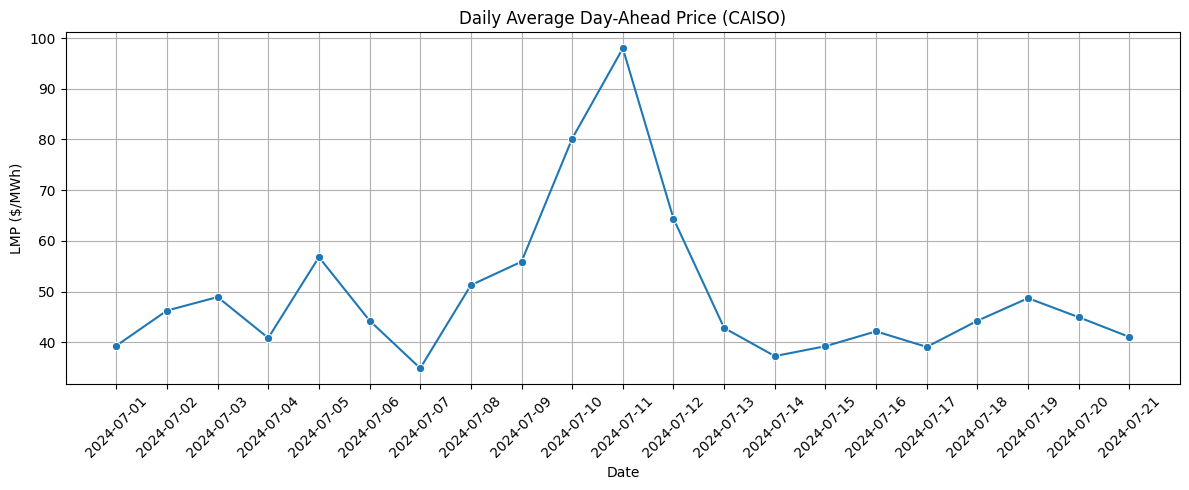

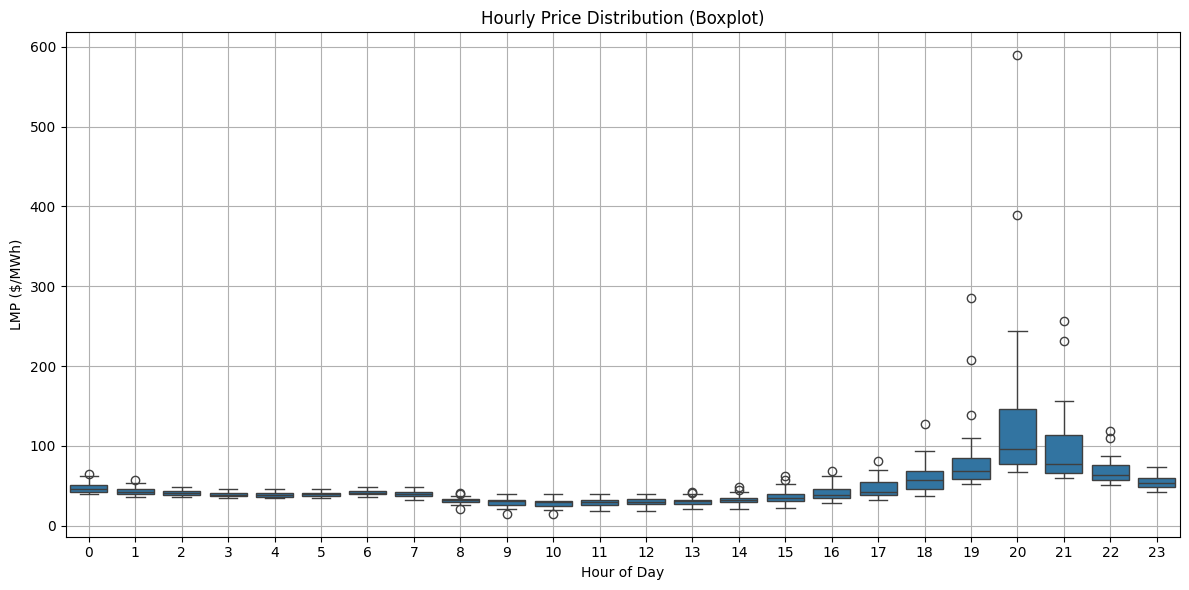

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

file_path = r"C:\Users\曦曦yyds\Desktop\20240701_20240722_PRC_LMP_DAM_20250719_15_20_37_v12.csv"

df = pd.read_csv(file_path)

# Keep only rows where LMP_TYPE is 'LMP' 
df = df[df["LMP_TYPE"] == "LMP"].copy()

# Construct datetime column
df["datetime"] = pd.to_datetime(df["OPR_DT"]) + pd.to_timedelta(df["OPR_HR"], unit='h')

# Add time-related features
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.dayofweek
df["day"] = df["datetime"].dt.day

# Remove outliers (extremely high/low values)
df = df[(df["MW"] > -100) & (df["MW"] < 1000)]

# Rolling mean feature (3-hour sliding window)
df["rolling_mean_3h"] = df["MW"].rolling(window=3).mean()

# Z-score normalization
df["zscore"] = (df["MW"] - df["MW"].mean()) / df["MW"].std()

# Descriptive statistics
desc_stats = df["MW"].describe().round(2)
print(" Descriptive Statistics:")
print(desc_stats)

# Daily average price
daily_avg = df.groupby("OPR_DT")["MW"].mean().reset_index()

# Visualization - Day-ahead price trend
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_avg, x="OPR_DT", y="MW", marker="o")
plt.title("Daily Average Day-Ahead Price (CAISO)")
plt.xlabel("Date")
plt.ylabel("LMP ($/MWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization - Hourly price fluctuation boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="MW", data=df)
plt.title("Hourly Price Distribution (Boxplot)")
plt.xlabel("Hour of Day")
plt.ylabel("LMP ($/MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

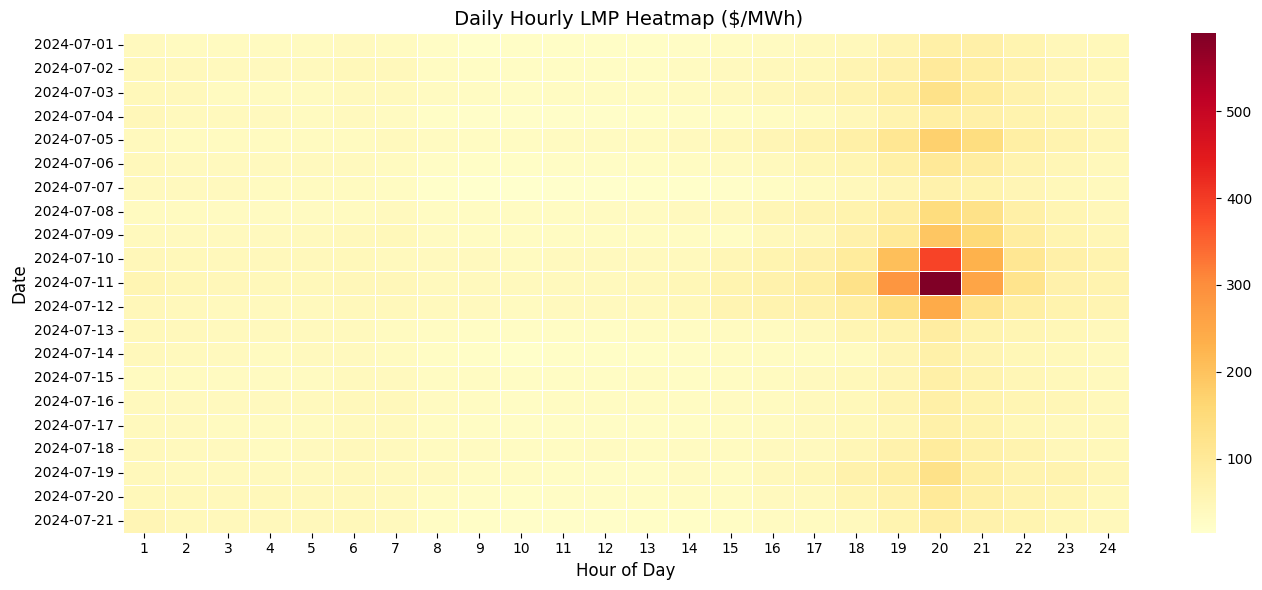

 Descriptive Statistics:
count    504.000000
mean      49.534420
std       41.035609
min       14.722080
25%       32.801985
50%       39.825390
75%       51.185115
max      589.596070
Name: MW, dtype: float64

 Detected 42 outliers. Example outliers:
                DATETIME           NODE         MW
1217 2024-07-11 19:00:00  0096WD_7_N001  589.59607
1096 2024-07-10 19:00:00  0096WD_7_N001  389.47272
1206 2024-07-11 18:00:00  0096WD_7_N001  284.66684
1215 2024-07-11 20:00:00  0096WD_7_N001  256.24142
1343 2024-07-12 19:00:00  0096WD_7_N001  244.51690


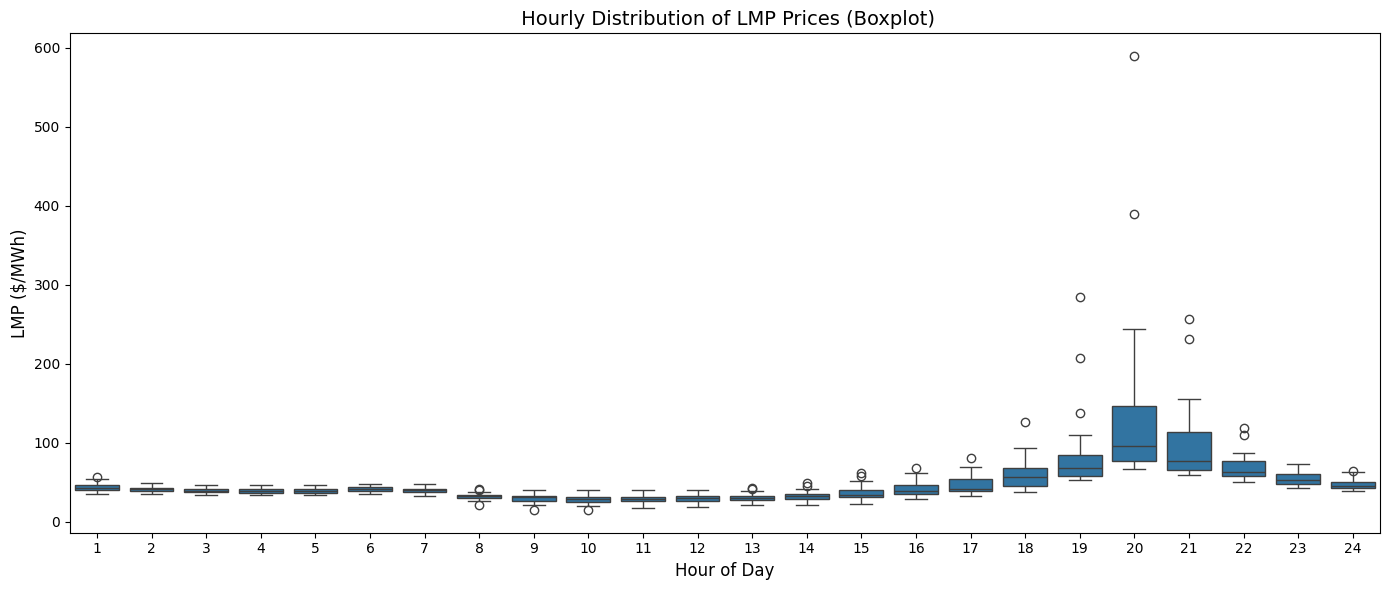

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\曦曦yyds\Desktop\20240701_20240722_PRC_LMP_DAM_20250719_15_20_37_v12.csv"
df = pd.read_csv(file_path)

# strip whitespace and convert to uppercase
df.columns = df.columns.str.strip().str.upper()

# Filter records of type 'LMP'
df = df[df['LMP_TYPE'] == 'LMP'].copy()

# Process time-related fields
df['DATE'] = pd.to_datetime(df['OPR_DT'])    
df['HOUR'] = df['OPR_HR'].astype(int)            
df['DATETIME'] = df['DATE'] + pd.to_timedelta(df['HOUR'] - 1, unit='h')  

# Plot hourly LMP heatmap by day
heatmap_data = df.pivot_table(index=df['DATE'].dt.strftime('%Y-%m-%d'),
                              columns='HOUR',
                              values='MW',
                              aggfunc='mean')

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5)
plt.title(' Daily Hourly LMP Heatmap ($/MWh)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Date', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(" Descriptive Statistics:")
print(df['MW'].describe())

# Outlier detection using IQR method
Q1 = df['MW'].quantile(0.25)
Q3 = df['MW'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df['MW'] < Q1 - 1.5 * IQR) | (df['MW'] > Q3 + 1.5 * IQR)
outliers = df[outlier_mask]

print(f"\n Detected {outliers.shape[0]} outliers. Example outliers:")
print(outliers[['DATETIME', 'NODE', 'MW']].sort_values(by='MW', ascending=False).head())

# Plot hourly distribution of LMP using boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x='HOUR', y='MW', data=df)
plt.title(' Hourly Distribution of LMP Prices (Boxplot)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('LMP ($/MWh)', fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
import os

file_path = r"C:\Users\曦曦yyds\Desktop\20240701_20240722_PRC_LMP_DAM_20250719_15_20_37_v12.csv"

df = pd.read_csv(file_path)

# Clean column names and filter for LMP type only
df.columns = df.columns.str.strip().str.upper()
df = df[df['LMP_TYPE'] == 'LMP'].copy()

# Construct time-related fields
df['DATE'] = pd.to_datetime(df['OPR_DT'])
df['HOUR'] = df['OPR_HR'].astype(int)
df['DATETIME'] = df['DATE'] + pd.to_timedelta(df['HOUR'] - 1, unit='h')

# Expand time-based features
df['WEEKDAY'] = df['DATE'].dt.weekday                           
df['IS_WEEKEND'] = df['WEEKDAY'].apply(lambda x: 1 if x >= 5 else 0)
df['HOUR_SIN'] = np.sin(2 * np.pi * df['HOUR'] / 24)            
df['HOUR_COS'] = np.cos(2 * np.pi * df['HOUR'] / 24)
df['DAY_OF_YEAR'] = df['DATE'].dt.dayofyear

# Identify top 3 nodes with highest price volatility (std deviation)
top_nodes = df.groupby('NODE')['MW'].std().sort_values(ascending=False).head(3).index.tolist()
df_top = df[df['NODE'].isin(top_nodes)].copy()

# Compute 6-hour rolling statistics (mean and std) per node
df_top = df_top.sort_values(['NODE', 'DATETIME'])
df_top['ROLLING_MEAN_6H'] = df_top.groupby('NODE')['MW'].transform(lambda x: x.rolling(6, min_periods=1).mean())
df_top['ROLLING_STD_6H'] = df_top.groupby('NODE')['MW'].transform(lambda x: x.rolling(6, min_periods=1).std())

output_path = r"C:\Users\曦曦yyds\Desktop\processed_lmp.csv"
df_top.to_csv(output_path, index=False)
print("Number of unique nodes included:", df_top['NODE'].nunique())
print("Time range:", df_top['DATETIME'].min(), "to", df_top['DATETIME'].max())

Number of unique nodes included: 1
Time range: 2024-07-01 00:00:00 to 2024-07-21 23:00:00


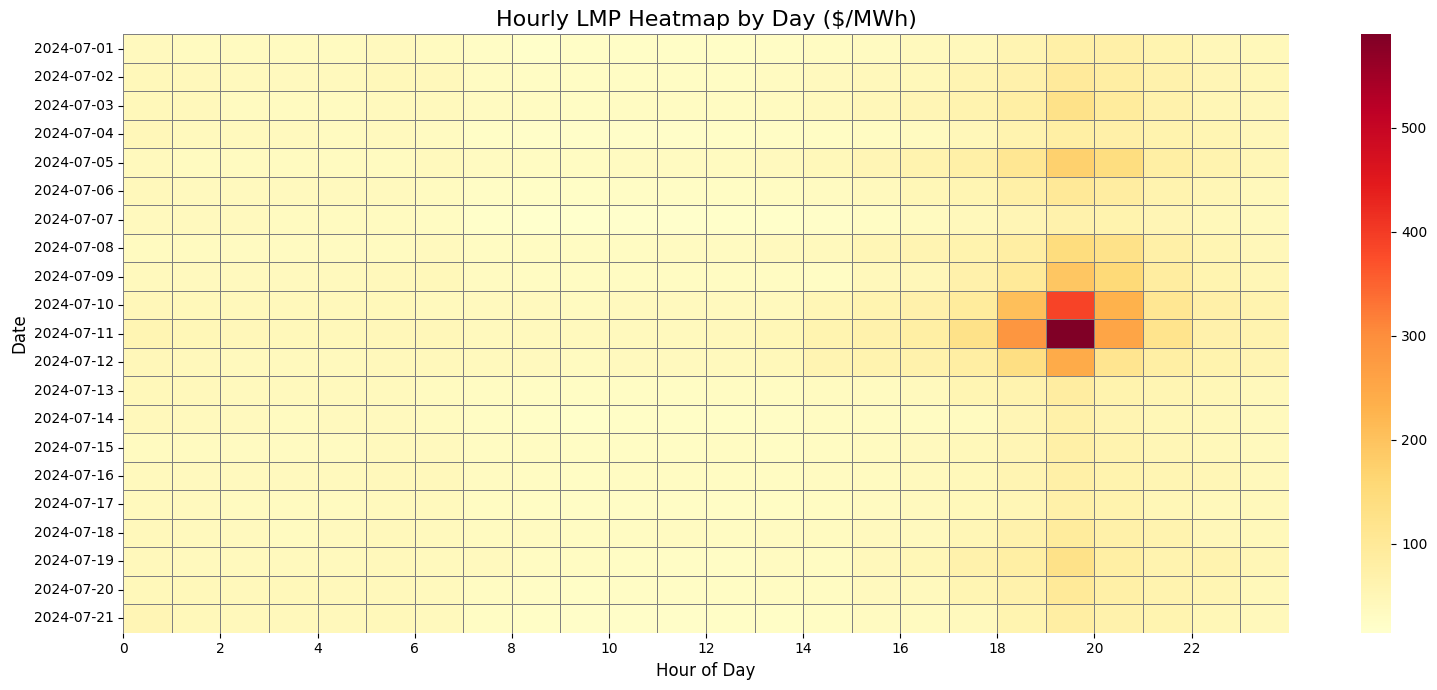

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

df = pd.read_csv(r"C:\Users\曦曦yyds\Desktop\processed_lmp.csv", parse_dates=['DATETIME'])

# Extract date and hour
df['DATE'] = df['DATETIME'].dt.date
df['HOUR'] = df['DATETIME'].dt.hour

# Create pivot table for heatmap
pivot_data = df.pivot_table(index='DATE', columns='HOUR', values='MW', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(16, 7))
ax = sns.heatmap(pivot_data, cmap="YlOrRd", linewidths=0.5, linecolor='gray')

plt.title("Hourly LMP Heatmap by Day ($/MWh)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Date", fontsize=12)
plt.xticks(ticks=range(0, 24, 2), labels=[str(i) for i in range(0, 24, 2)])
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

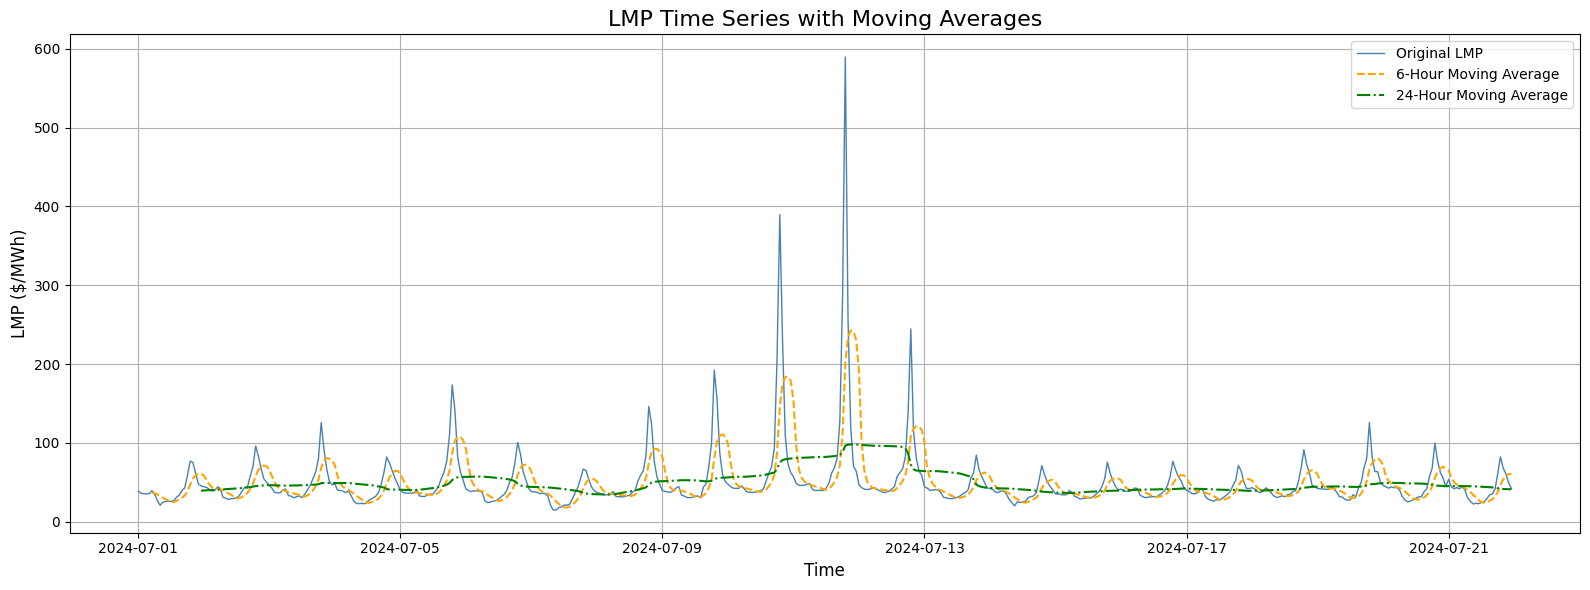

In [10]:
# Add rolling average lines (6-hour and 24-hour windows)
df['LMP_MA_6H'] = df['MW'].rolling(window=6).mean()
df['LMP_MA_24H'] = df['MW'].rolling(window=24).mean()

plt.figure(figsize=(16, 6))
plt.plot(df['DATETIME'], df['MW'], label='Original LMP', color='steelblue', linewidth=1)
plt.plot(df['DATETIME'], df['LMP_MA_6H'], label='6-Hour Moving Average', color='orange', linestyle='--')
plt.plot(df['DATETIME'], df['LMP_MA_24H'], label='24-Hour Moving Average', color='green', linestyle='-.')

plt.title("LMP Time Series with Moving Averages", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("LMP ($/MWh)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\曦曦yyds\AppData\Local\Temp\ipykernel_25736\2578882721.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HOUR', y='MW', data=df, palette="Set2", showfliers=True)


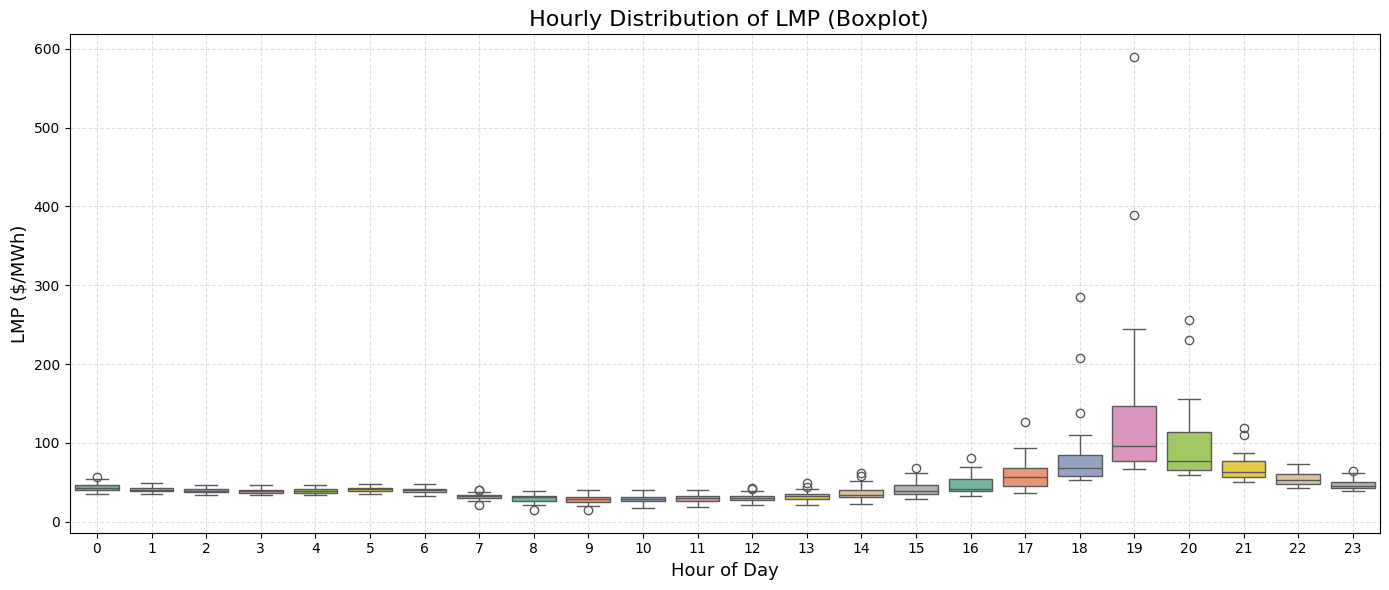

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\曦曦yyds\Desktop\processed_lmp.csv", parse_dates=['DATETIME'])

df['HOUR'] = df['DATETIME'].dt.hour

# Draw hourly LMP boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x='HOUR', y='MW', data=df, palette="Set2", showfliers=True)

plt.title(' Hourly Distribution of LMP (Boxplot)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=13)
plt.ylabel('LMP ($/MWh)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



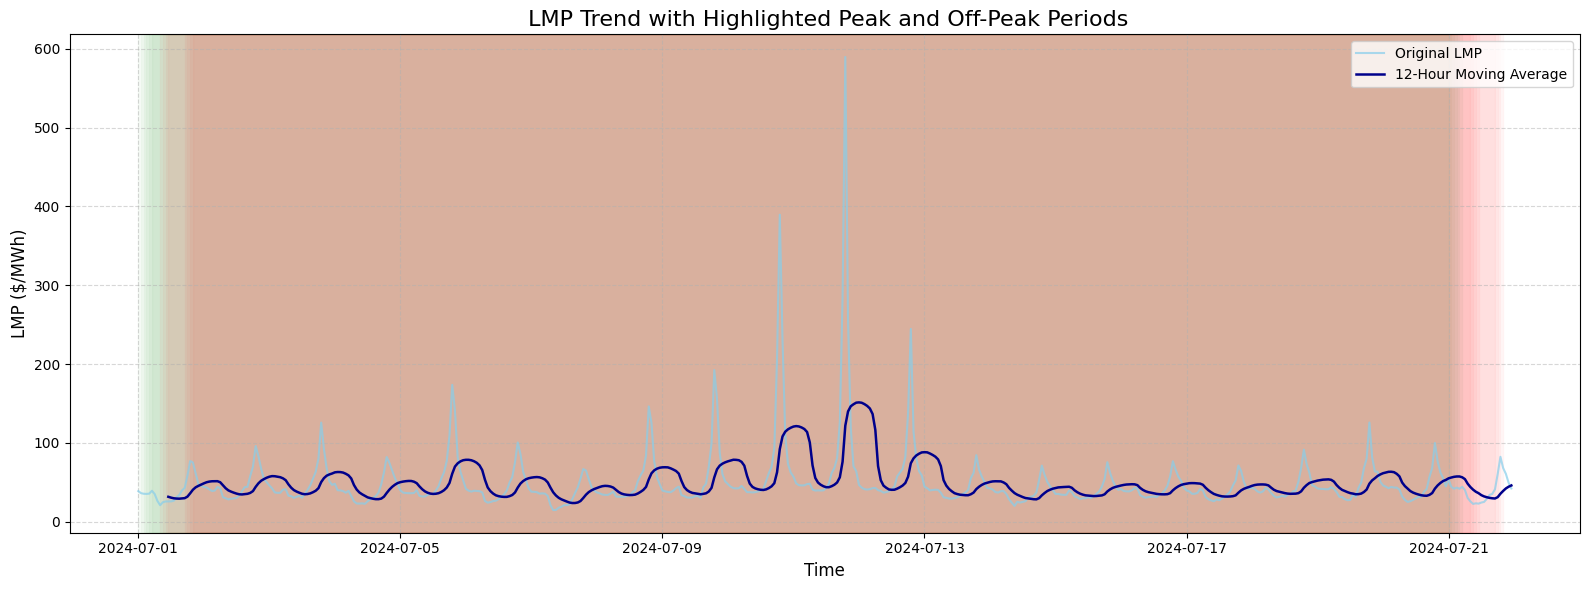

In [12]:
import matplotlib.dates as mdates

# Add 12-hour rolling average
df['LMP_MA_12H'] = df['MW'].rolling(window=12).mean()

# Plot time series
plt.figure(figsize=(16, 6))
plt.plot(df['DATETIME'], df['MW'], label='Original LMP', color='skyblue', alpha=0.7)
plt.plot(df['DATETIME'], df['LMP_MA_12H'], label='12-Hour Moving Average', color='darkblue', linewidth=1.8)

# Highlight peak and off-peak time zones
for hour in range(0, 24):
    if hour in [0, 1, 2, 3, 4, 5]:  
        plt.axvspan(df[df['DATETIME'].dt.hour == hour]['DATETIME'].min(),
                    df[df['DATETIME'].dt.hour == hour]['DATETIME'].max(),
                    color='green', alpha=0.03)
    elif hour in [8, 9, 10, 11, 17, 18, 19, 20]: 
        plt.axvspan(df[df['DATETIME'].dt.hour == hour]['DATETIME'].min(),
                    df[df['DATETIME'].dt.hour == hour]['DATETIME'].max(),
                    color='red', alpha=0.03)

plt.title(" LMP Trend with Highlighted Peak and Off-Peak Periods", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("LMP ($/MWh)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Found 1 nodes: ['0096WD_7_N001']


C:\Users\曦曦yyds\AppData\Local\Temp\ipykernel_25736\2386127200.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=node_df, x='HOUR', y='MW', ax=ax, palette='husl')


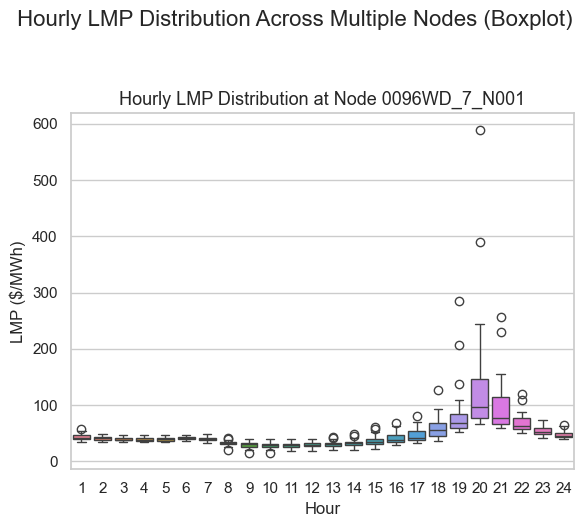

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\曦曦yyds\Desktop\processed_lmp.csv"
df = pd.read_csv(file_path, parse_dates=['DATETIME'])

# Extract list of nodes
nodes = df['NODE'].unique()
print(f"Found {len(nodes)} nodes: {nodes}")

plt.rcParams['font.sans-serif'] = ['Arial']  
plt.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid")

# Create subplots arranged horizontally
fig, axes = plt.subplots(nrows=1, ncols=len(nodes), figsize=(6 * len(nodes), 5), sharey=True)

if len(nodes) == 1:
    axes = [axes]  

# Plot for each node
for ax, node in zip(axes, nodes):
    node_df = df[df['NODE'] == node].copy()
    sns.boxplot(data=node_df, x='HOUR', y='MW', ax=ax, palette='husl')
    ax.set_title(f'Hourly LMP Distribution at Node {node}', fontsize=13)
    ax.set_xlabel('Hour')
    ax.set_ylabel('LMP ($/MWh)' if ax == axes[0] else '')
    ax.tick_params(axis='x', rotation=0)

plt.suptitle(' Hourly LMP Distribution Across Multiple Nodes (Boxplot)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np

file_path = r"C:\Users\曦曦yyds\Desktop\processed_lmp.csv"
df = pd.read_csv(file_path, parse_dates=['DATETIME'])

# Create time-based features
df['HOUR'] = df['DATETIME'].dt.hour
df['DAYOFWEEK'] = df['DATETIME'].dt.dayofweek  # Day of week (0 = Monday)
df['WEEKDAY'] = (df['DAYOFWEEK'] < 5).astype(int)  # 1 if weekday, 0 if weekend

# Create lag features (for XGBoost)
for lag in [1, 2, 3, 24, 48]:
    df[f'LAG_{lag}'] = df['MW'].shift(lag)

# Create rolling mean features
df['ROLL_MEAN_6'] = df['MW'].rolling(6).mean()
df['ROLL_MEAN_12'] = df['MW'].rolling(12).mean()

# Drop rows with missing values
df.dropna(inplace=True)

processed_model_path = r"C:\Users\曦曦yyds\Desktop\model_ready_lmp.csv"
df.to_csv(processed_model_path, index=False)


 XGBoost prediction completed
MAE: 3.391
RMSE: 5.222


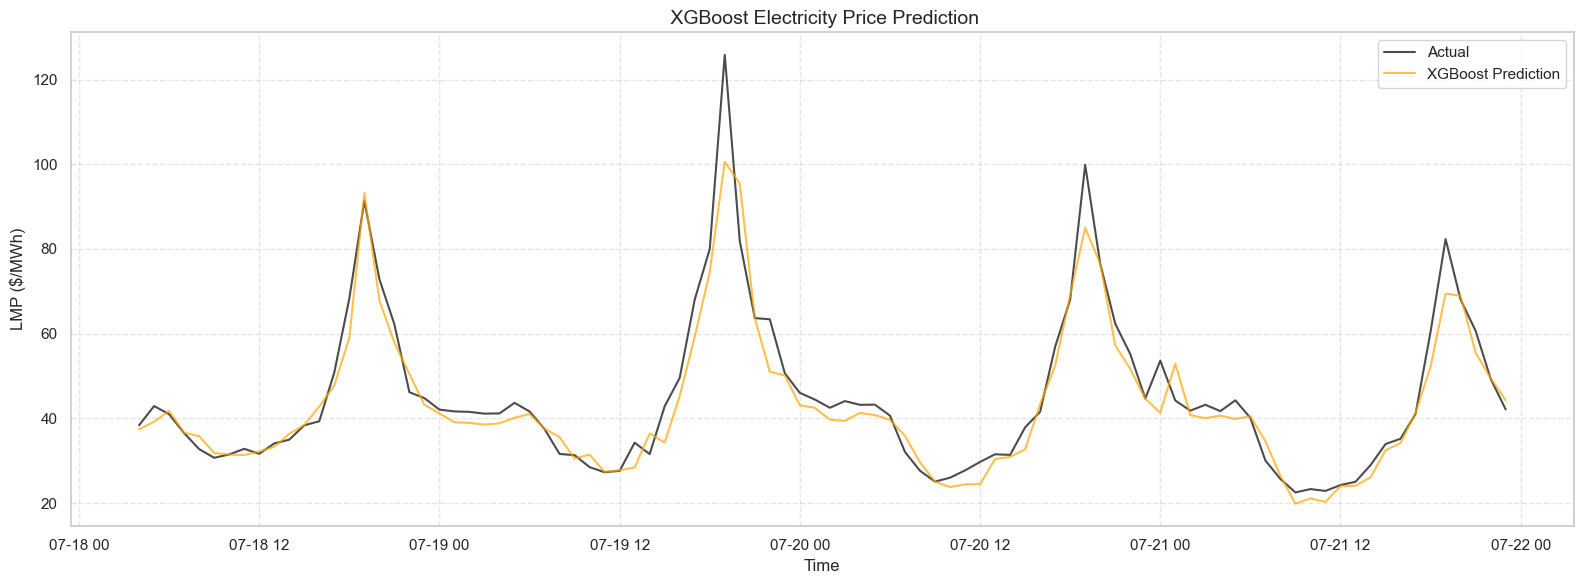

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

data_path = r"C:\Users\曦曦yyds\Desktop\model_ready_lmp.csv"
df = pd.read_csv(data_path, parse_dates=['DATETIME'])

# Define features and target variable
features = ['HOUR', 'DAYOFWEEK', 'WEEKDAY',
            'LAG_1', 'LAG_2', 'LAG_3', 'LAG_24', 'LAG_48',
            'ROLL_MEAN_6', 'ROLL_MEAN_12']
target = 'MW'

X = df[features]
y = df[target]

# Split into training and testing sets (80% / 20%)
X_train, X_test, y_train, y_test, dt_train, dt_test = train_test_split(
    X, y, df['DATETIME'], test_size=0.2, shuffle=False)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" XGBoost prediction completed")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Visualize prediction results
plt.figure(figsize=(16, 6))
plt.plot(dt_test.values, y_test.values, label='Actual', alpha=0.7, color='black')
plt.plot(dt_test.values, y_pred, label='XGBoost Prediction', alpha=0.7, color='orange')
plt.title(" XGBoost Electricity Price Prediction", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("LMP ($/MWh)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

result_df = pd.DataFrame({
    'DATETIME': dt_test.values,
    'TRUE_LMP': y_test.values,
    'PREDICTED_LMP': y_pred
})
output_path = r"C:\Users\曦曦yyds\Desktop\xgb_baseline_prediction.csv"
result_df.to_csv(output_path, index=False)

In [1]:
import tensorflow as tf
print("TF:", tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
print("Keras ok")


TF: 2.15.1
Keras ok




Epoch 1/30

10/10 [==============================] - 2s 54ms/step - loss: 0.0086 - val_loss: 0.0012
Epoch 2/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 2.6728e-04
Epoch 3/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 6.2802e-04
Epoch 4/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 6.3906e-04
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 4.7299e-04
Epoch 6/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 3.8644e-04
Epoch 7/30
3/3 [==============================] - 0s 3ms/step
 LSTM prediction completed
MAE: 14.381
RMSE: 16.917


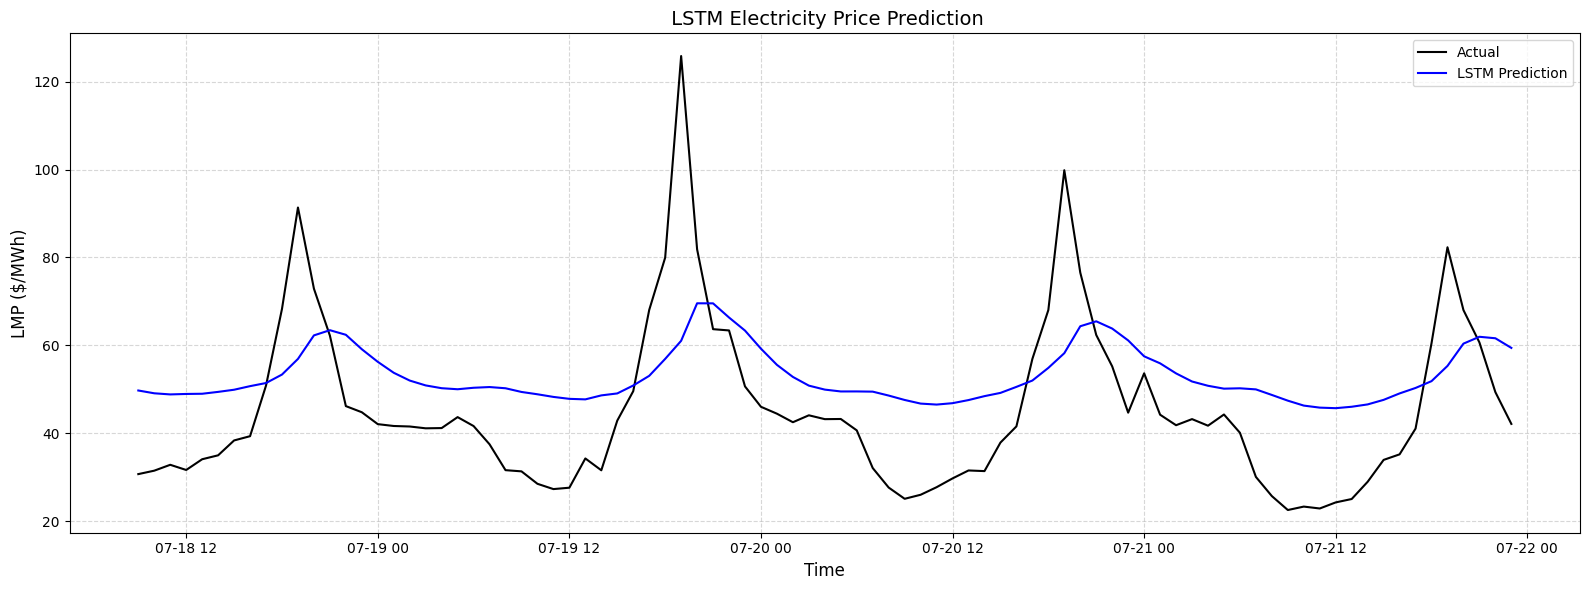

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

data_path = r"C:\Users\曦曦yyds\Desktop\model_ready_lmp.csv"
df = pd.read_csv(data_path, parse_dates=['DATETIME'])

# Prepare LSTM input
lookback = 24
data = df[['MW']].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split (80% / 20%)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dt_test = df['DATETIME'].values[lookback:][split_idx:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=30, batch_size=32,
          validation_split=0.1, callbacks=[early_stop], verbose=1)

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(" LSTM prediction completed")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Visualize prediction results
plt.figure(figsize=(16, 6))
plt.plot(dt_test, y_test_rescaled, label='Actual', color='black')
plt.plot(dt_test, y_pred_rescaled, label='LSTM Prediction', color='blue')
plt.title(" LSTM Electricity Price Prediction", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("LMP ($/MWh)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

result_df = pd.DataFrame({
    'DATETIME': dt_test,
    'TRUE_LMP': y_test_rescaled.flatten(),
    'PREDICTED_LMP': y_pred_rescaled.flatten()
})
output_path = r"C:\Users\曦曦yyds\Desktop\lstm_baseline_prediction.csv"
result_df.to_csv(output_path, index=False)

Epoch 1/30
10/10 [==============================] - 2s 73ms/step - loss: 0.0083 - val_loss: 7.2762e-04
Epoch 2/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 3.3489e-04
Epoch 3/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 6.4119e-04
Epoch 4/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 9.5319e-04
Epoch 5/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 3.6061e-04
Epoch 6/30
10/10 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 5.6842e-04
Epoch 7/30
3/3 [==============================] - 0s 3ms/step
 LSTM prediction completed
MAE: 11.852
RMSE: 15.208


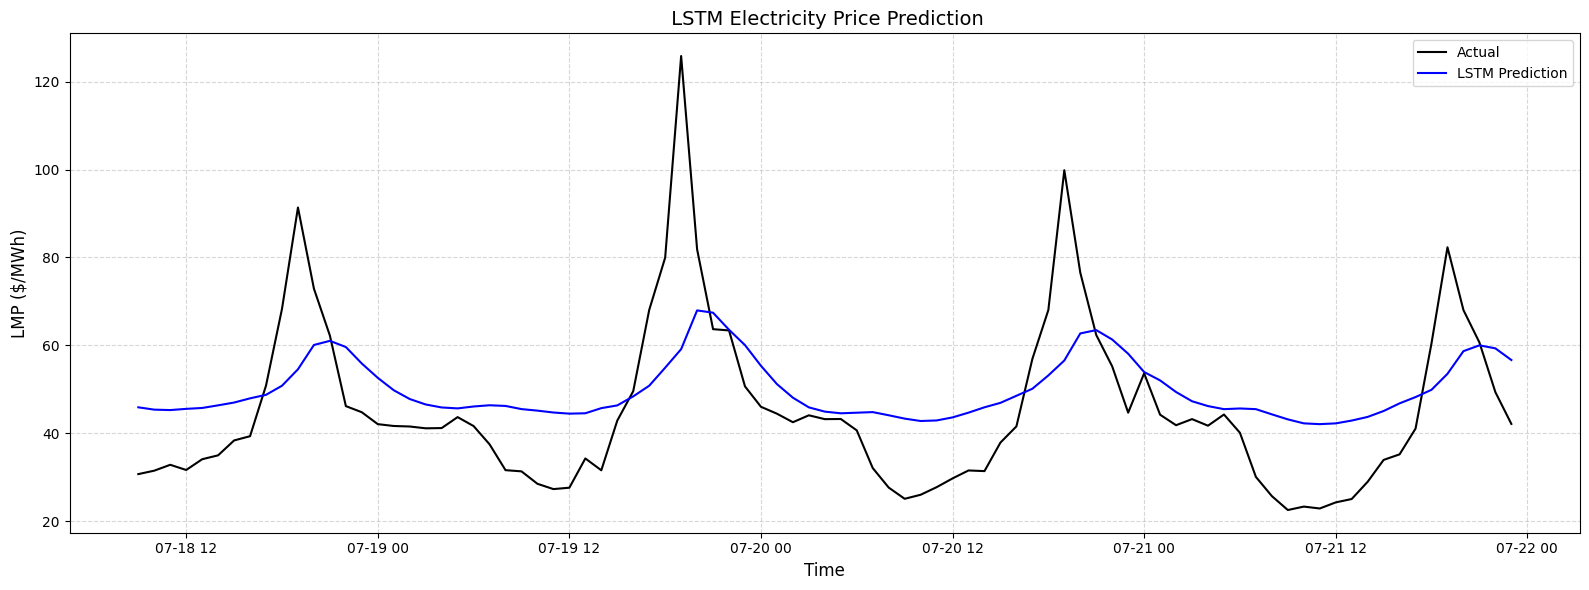

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

data_path = r"C:\Users\曦曦yyds\Desktop\model_ready_lmp.csv"
df = pd.read_csv(data_path, parse_dates=['DATETIME'])

# Prepare LSTM input
lookback = 24
data = df[['MW']].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split (80% / 20%)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dt_test = df['DATETIME'].values[lookback:][split_idx:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=30, batch_size=32,
          validation_split=0.1, callbacks=[early_stop], verbose=1)

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(" LSTM prediction completed")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Visualize prediction results
plt.figure(figsize=(16, 6))
plt.plot(dt_test, y_test_rescaled, label='Actual', color='black')
plt.plot(dt_test, y_pred_rescaled, label='LSTM Prediction', color='blue')
plt.title(" LSTM Electricity Price Prediction", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("LMP ($/MWh)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

result_df = pd.DataFrame({
    'DATETIME': dt_test,
    'TRUE_LMP': y_test_rescaled.flatten(),
    'PREDICTED_LMP': y_pred_rescaled.flatten()
})
output_path = r"C:\Users\曦曦yyds\Desktop\lstm_baseline_prediction.csv"
result_df.to_csv(output_path, index=False)


In [ ]:
import pandas as pd
import numpy as np

file_path = r"C:\Users\曦曦yyds\Desktop\dataSet_Oct2021.csv"
df = pd.read_csv(file_path)

# Clean column names (remove whitespace)
df.columns = df.columns.str.strip()

# Convert datetime fields
df['request_entry_time'] = pd.to_datetime(df['request_entry_time'])
df['expected_departure'] = pd.to_datetime(df['expected_departure'])

# Construct user behavior features
df['arrival_hour'] = df['request_entry_time'].dt.hour  # Hour of arrival
df['park_duration'] = (df['expected_departure'] - df['request_entry_time']).dt.total_seconds() / 3600  # Parking duration (hours)
df['energy_gap'] = df['kwh_requested'] - df['energy_charged']  # Energy deviation (expected - actual)

# Energy demand level (discretization)
df['demand_level'] = pd.cut(df['kwh_requested'], bins=[0, 8, 16, np.inf],
                            labels=['Low', 'Medium', 'High'])

# Price sensitivity (whether the user continues during paid period)
df['price_sensitive'] = df['afterPaid'].apply(lambda x: 'Not Sensitive' if x else 'Free Period')

# Keep key fields and drop missing values
features_df = df[['driverId', 'arrival_hour', 'park_duration', 'kwh_requested',
                  'energy_charged', 'energy_gap', 'demand_level', 'price_sensitive']].dropna()

save_path = r"C:\Users\曦曦yyds\Desktop\processed_ev_user_features.csv"
features_df.to_csv(save_path, index=False)

print("Processing completed")


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r"C:\Users\曦曦yyds\Desktop\processed_ev_user_features.csv"
df = pd.read_csv(file_path)

Processing completed


C:\Users\曦曦yyds\AppData\Local\Temp\ipykernel_24764\9137083.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='demand_level', data=df, palette='pastel')


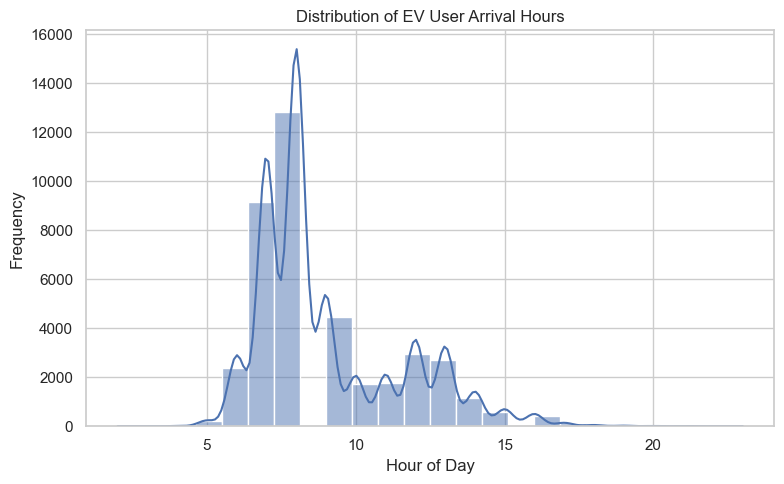

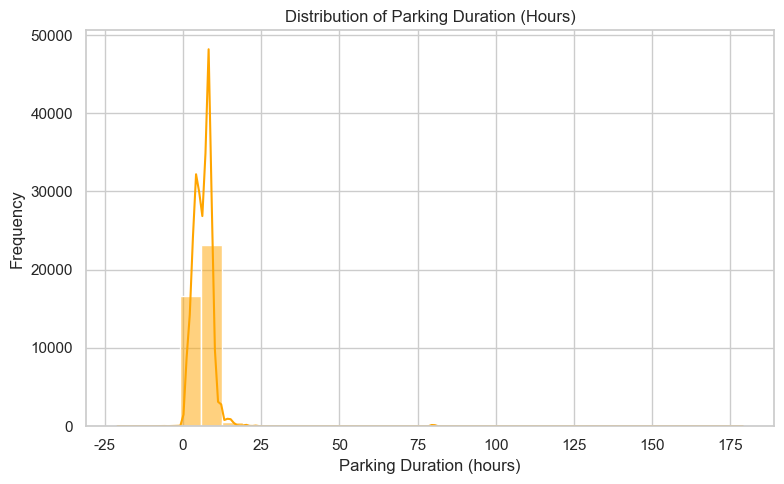

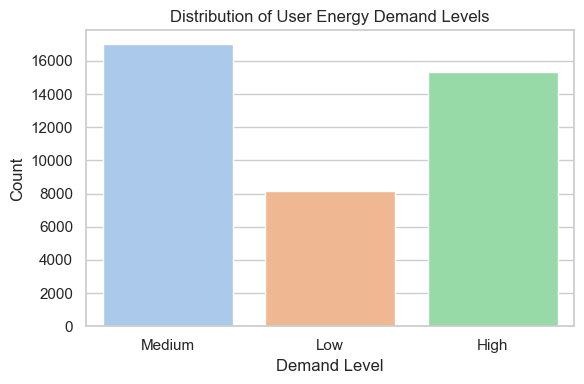

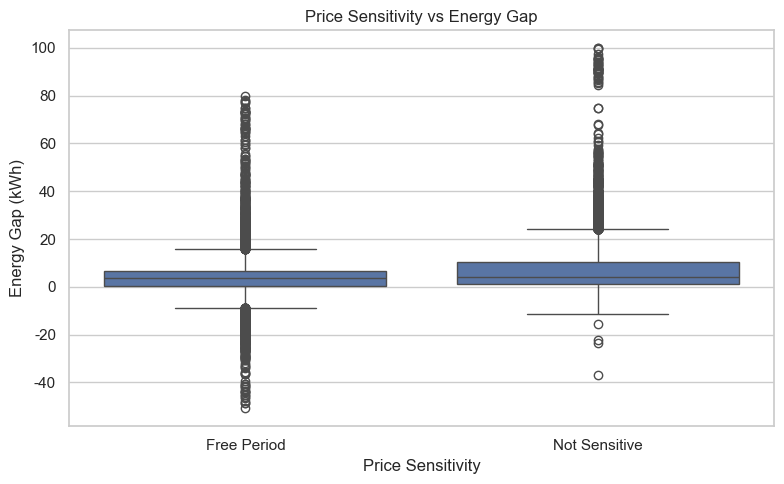

In [8]:
# Figure 1: Distribution of EV Arrival Hours
plt.figure(figsize=(8, 5))
sns.histplot(df['arrival_hour'], bins=24, kde=True)
plt.title("Distribution of EV User Arrival Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_1_arrival_hour.png")  # Save to desktop

# Figure 2: Distribution of Parking Duration
plt.figure(figsize=(8, 5))
sns.histplot(df['park_duration'], bins=30, kde=True, color='orange')
plt.title("Distribution of Parking Duration (Hours)")
plt.xlabel("Parking Duration (hours)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_2_park_duration.png")

# Figure 3: Distribution of Energy Demand Levels
plt.figure(figsize=(6, 4))
sns.countplot(x='demand_level', data=df, palette='pastel')
plt.title("Distribution of User Energy Demand Levels")
plt.xlabel("Demand Level")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_3_demand_level.png")

# Figure 4: Price Sensitivity vs Energy Gap (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='price_sensitive', y='energy_gap', data=df)
plt.title("Price Sensitivity vs Energy Gap")
plt.xlabel("Price Sensitivity")
plt.ylabel("Energy Gap (kWh)")
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_4_price_sensitivity_energygap.png")

In [ ]:
# PPO
import pandas as pd
import numpy as np

input_path = r"C:\Users\曦曦yyds\Desktop\processed_ev_user_features.csv"
output_path = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_input.csv"

df = pd.read_csv(input_path)

# Step 1: Construct State Space
# Encode demand level as numeric labels: Low=0, Medium=1, High=2
demand_level_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['demand_level_encoded'] = df['demand_level'].map(demand_level_mapping)

# Select relevant state features
state_columns = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive']
df_state = df[state_columns].copy()

# Step 2: Define Discrete Action Space
# Define 5 pricing actions (in $/kWh): [-0.2, -0.1, 0.0, +0.1, +0.2]
action_mapping = {0: -0.2, 1: -0.1, 2: 0.0, 3: 0.1, 4: 0.2}

# Randomly assign actions to users for simulation
np.random.seed(42)
df_state['action_index'] = np.random.randint(0, 5, size=len(df_state))
df_state['action_value'] = df_state['action_index'].map(action_mapping)

# Step 3: Save the PPO input table
df_state.to_csv(output_path, index=False)
print(f"PPO input table saved to: {output_path}")

PPO input table saved to: C:\Users\曦曦yyds\Desktop\ppo_state_action_input.csv


In [ ]:
import pandas as pd

input_path = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_input.csv"
output_path_cleaned = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_input_cleaned.csv"

df_ppo = pd.read_csv(input_path)

# Remove rows with invalid parking duration (e.g., negative)
df_ppo = df_ppo[df_ppo['park_duration'] > 0]

# Convert price_sensitive to binary flag
df_ppo['price_sensitive_flag'] = df_ppo['price_sensitive'].map({
    'Free Period': 1,
    'Not Sensitive': 0
})

df_ppo.to_csv(output_path_cleaned, index=False)
print(f"Cleaned PPO input table saved to: {output_path_cleaned}")

Cleaned PPO input table saved to: C:\Users\曦曦yyds\Desktop\ppo_state_action_input_cleaned.csv


In [ ]:
import pandas as pd

input_path_cleaned = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_input_cleaned.csv"
output_path_with_reward = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_with_reward.csv"

df = pd.read_csv(input_path_cleaned)

# Revenue = unit_price * delivered_energy
# delivered_energy = min(energy_gap, park_duration × max_rate), where max_rate = 7.2 kW
max_rate = 7.2
df['delivered_energy'] = df[['energy_gap', 'park_duration']].min(axis=1) * max_rate
df['delivered_energy'] = df['delivered_energy'].clip(lower=0)
df['revenue'] = df['action_value'] * df['delivered_energy']

# Peak time penalty: arrival during 8–11 or 16–19
df['peak_penalty'] = df['arrival_hour'].apply(lambda h: 1 if (8 <= h <= 11) or (16 <= h <= 19) else 0)

# Discomfort penalty: if price increased and user is price-sensitive
df['discomfort_penalty'] = df.apply(
    lambda row: 1 if row['price_sensitive_flag'] == 1 and row['action_value'] > 0 else 0,
    axis=1
)

# Final reward function: weighted sum
alpha, beta, gamma = 1.0, 5.0, 3.0
df['reward'] = alpha * df['revenue'] - beta * df['peak_penalty'] - gamma * df['discomfort_penalty']

df.to_csv(output_path_with_reward, index=False)
print(f"PPO input table with reward saved to: {output_path_with_reward}")

PPO input table with reward saved to: C:\Users\曦曦yyds\Desktop\ppo_state_action_with_reward.csv


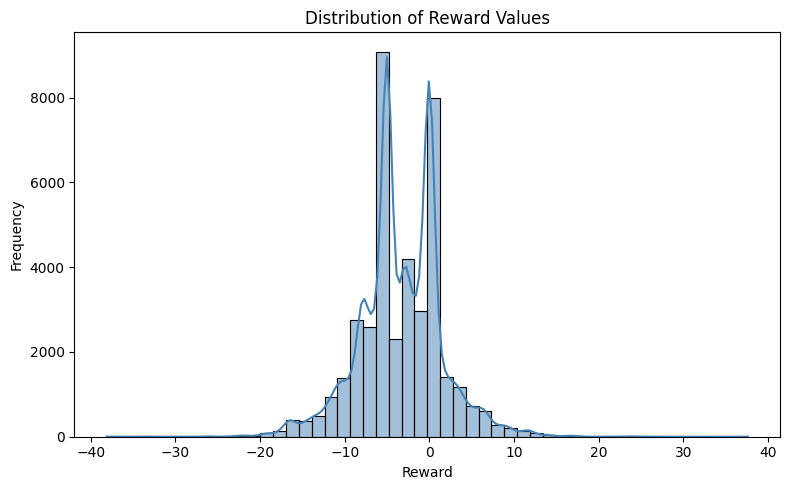

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

file_path = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_with_reward.csv"
df = pd.read_csv(file_path)

# Visualization 1: Distribution of Reward
plt.figure(figsize=(8, 5))
sns.histplot(df['reward'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Reward Values")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_reward_distribution.png")
plt.show()

# Visualization 2: 3D scatter plot (reward vs user behavior)
fig = px.scatter_3d(
    df, x='arrival_hour', y='park_duration', z='reward',
    color='price_sensitive_flag',
    title='3D EV User Embedding: Reward vs Time vs Parking Duration',
    labels={'arrival_hour': 'Arrival Hour', 'park_duration': 'Parking Duration', 'reward': 'Reward'},
    color_continuous_scale='Viridis'
)
fig.write_html(r"C:\Users\曦曦yyds\Desktop\viz_3d_user_embedding.html")
fig.show()


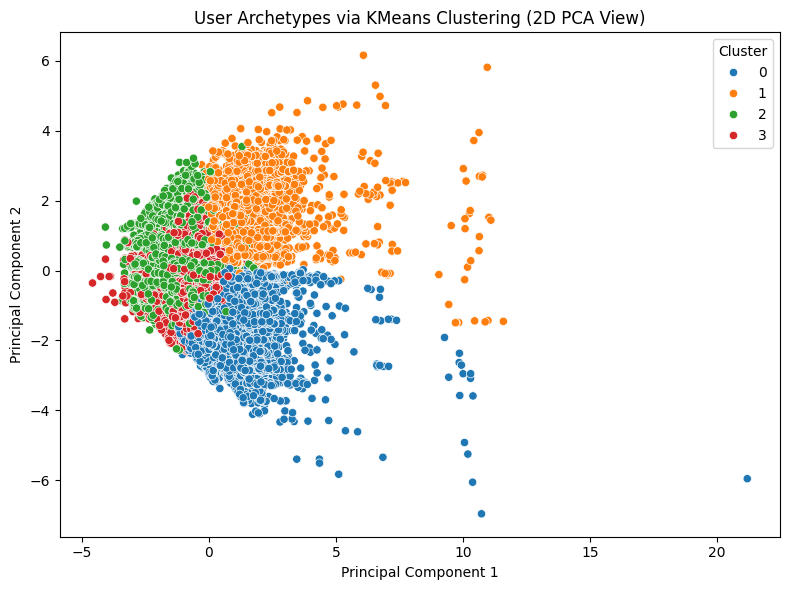

===== User Archetype Summary by Cluster =====
         arrival_hour  park_duration  energy_gap  demand_level_encoded  \
cluster                                                                  
0                8.48           7.41        9.43                  1.73   
1                8.17           7.77       10.31                  1.75   
2               12.97           3.57        2.97                  0.86   
3                7.72           6.66        0.68                  0.70   

         price_sensitive_flag  action_index  reward  
cluster                                              
0                        0.54          0.69   -8.66  
1                        0.50          3.40    2.00  
2                        0.78          2.04   -1.79  
3                        0.73          2.09   -3.70  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
input_path = r"C:\Users\曦曦yyds\Desktop\ppo_state_action_with_reward.csv"
df = pd.read_csv(input_path)

# Select Features for Clustering
features_for_clustering = [
    'arrival_hour', 'park_duration', 'energy_gap',
    'demand_level_encoded', 'price_sensitive_flag',
    'action_index', 'reward'
]
X = df[features_for_clustering].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans Clustering
k = 4  # Can adjust between 3–6 and validate using silhouette score
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Apply PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title("User Archetypes via KMeans Clustering (2D PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_user_clusters.png")
plt.show()

# Archetype Profiling
cluster_summary = df.groupby('cluster')[features_for_clustering].mean().round(2)
print("===== User Archetype Summary by Cluster =====")
print(cluster_summary)

# Save clustering result for downstream PPO use
df.to_csv(r"C:\Users\曦曦yyds\Desktop\ppo_user_clustered.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler

# Load Data
input_path = r"C:\Users\曦曦yyds\Desktop\ppo_user_clustered.csv"
df = pd.read_csv(input_path)
state_cols = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive_flag']

X = df[state_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

states = torch.tensor(X_scaled, dtype=torch.float32)
actions = torch.tensor(df['action_index'].values, dtype=torch.int64)
rewards = torch.tensor(df['reward'].values, dtype=torch.float32)

# Define PPO Policy Network
class PolicyNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.layers(x)

input_dim = states.shape[1]
output_dim = 5
policy = PolicyNet(input_dim, output_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Training Loop
epochs = 10
reward_history = []

for epoch in range(epochs):
    probs = policy(states)
    dist = Categorical(probs)
    log_probs = dist.log_prob(actions)

    loss = -(log_probs * rewards).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_reward = rewards.mean().item()
    reward_history.append(avg_reward)
    print(f"Epoch {epoch+1}/{epochs} - Avg Reward: {avg_reward:.2f}")

reward_df = pd.DataFrame({'epoch': list(range(1, epochs+1)), 'avg_reward': reward_history})
reward_df.to_csv(r"C:\Users\曦曦yyds\Desktop\ppo_training_reward_curve.csv", index=False)
print("Training reward curve saved.")

Epoch 1/10 - Avg Reward: -3.38
Epoch 2/10 - Avg Reward: -3.38
Epoch 3/10 - Avg Reward: -3.38
Epoch 4/10 - Avg Reward: -3.38
Epoch 5/10 - Avg Reward: -3.38
Epoch 6/10 - Avg Reward: -3.38
Epoch 7/10 - Avg Reward: -3.38
Epoch 8/10 - Avg Reward: -3.38
Epoch 9/10 - Avg Reward: -3.38
Epoch 10/10 - Avg Reward: -3.38
Training reward curve saved.


Evaluation result saved to: C:\Users\曦曦yyds\Desktop\ppo_policy_evaluation.csv


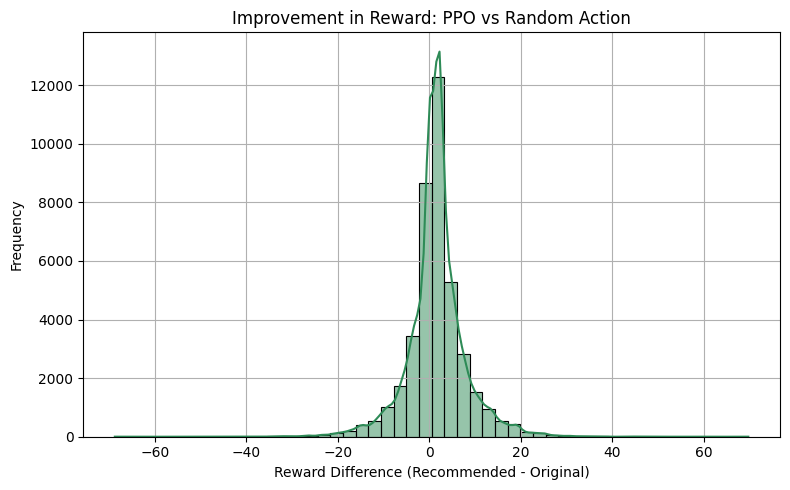

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\曦曦yyds\Desktop\ppo_user_clustered.csv"
df_eval = pd.read_csv(file_path)

# Reuse state preprocessing
state_cols = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive_flag']
X = df_eval[state_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
states = torch.tensor(X_scaled, dtype=torch.float32)

# Predict optimal action using trained policy
policy.eval()
with torch.no_grad():
    probs = policy(states)
    dist = Categorical(probs)
    recommended_actions = dist.sample().numpy()

# Map action and compute new reward
df_eval['recommended_action_index'] = recommended_actions
df_eval['recommended_action_value'] = df_eval['recommended_action_index'].map({0: -0.2, 1: -0.1, 2: 0.0, 3: 0.1, 4: 0.2})
max_rate = 7.2
df_eval['delivered_energy'] = np.minimum(df_eval['energy_gap'], df_eval['park_duration']) * max_rate
df_eval['revenue'] = df_eval['recommended_action_value'] * df_eval['delivered_energy']
df_eval['peak_penalty'] = df_eval['arrival_hour'].apply(lambda h: 1 if (8 <= h <= 11 or 16 <= h <= 19) else 0)
df_eval['discomfort_penalty'] = (df_eval['price_sensitive_flag'] == 1) & (df_eval['recommended_action_value'] > 0)
alpha, beta, gamma = 1.0, 3.0, 2.0
df_eval['recommended_reward'] = alpha * df_eval['revenue'] - beta * df_eval['peak_penalty'] - gamma * df_eval['discomfort_penalty']

eval_output_path = r"C:\Users\曦曦yyds\Desktop\ppo_policy_evaluation.csv"
df_eval.to_csv(eval_output_path, index=False)
print(f"Evaluation result saved to: {eval_output_path}")

plt.figure(figsize=(8, 5))
sns.histplot(df_eval['recommended_reward'] - df_eval['reward'], bins=50, kde=True, color='seagreen')
plt.title("Improvement in Reward: PPO vs Random Action")
plt.xlabel("Reward Difference (Recommended - Original)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\ppo_policy_eval_diff.png")
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

file_path = r"C:\Users\曦曦yyds\Desktop\ppo_user_clustered.csv"
output_dir = r"C:\Users\曦曦yyds\Desktop\ppo_sensitivity_results"
os.makedirs(output_dir, exist_ok=True)

# Data loading & preprocessing
df = pd.read_csv(file_path)
state_cols = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive_flag']
X = df[state_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
states = torch.tensor(X_scaled, dtype=torch.float32)

# Policy network
class PolicyNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)

# Sensitivity parameter combinations
alpha_values = [0.5, 1.0, 1.5]
beta_values = [2.0, 3.0, 4.0]
gamma_values = [1.0, 2.0, 3.0]
epochs = 20
results = []

# Sensitivity analysis loop
for alpha in alpha_values:
    for beta in beta_values:
        for gamma in gamma_values:
            policy = PolicyNet(states.shape[1], 5)
            optimizer = optim.Adam(policy.parameters(), lr=0.005)
            reward_history = []
            for epoch in range(epochs):
                probs = policy(states)
                dist = Categorical(probs)
                actions = dist.sample()
                log_probs = dist.log_prob(actions)

                df_temp = df.copy()
                df_temp['action_index'] = actions.numpy()
                df_temp['action_value'] = df_temp['action_index'].map({0: -0.2, 1: -0.1, 2: 0.0, 3: 0.1, 4: 0.2})
                max_rate = 7.2
                delivered_energy = np.minimum(df_temp['energy_gap'], df_temp['park_duration']) * max_rate
                revenue = df_temp['action_value'] * delivered_energy
                peak_penalty = df_temp['arrival_hour'].apply(lambda h: 1 if (8 <= h <= 11 or 16 <= h <= 19) else 0)
                discomfort_penalty = (df_temp['price_sensitive_flag'] == 1) & (df_temp['action_value'] > 0)

                rewards = alpha * revenue - beta * peak_penalty - gamma * discomfort_penalty
                rewards = torch.tensor(rewards.values, dtype=torch.float32)

                loss = -(log_probs * rewards).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_reward = rewards.mean().item()
                reward_history.append(avg_reward)

            label = f"α={alpha}, β={beta}, γ={gamma}"
            results.append({'label': label, 'reward_history': reward_history})

# Interactive Plotly Visualization
fig = go.Figure()
for result in results:
    fig.add_trace(go.Scatter(
        x=list(range(1, epochs + 1)),
        y=result['reward_history'],
        mode='lines+markers',
        name=result['label']
    ))
fig.update_layout(
    title="PPO Reward Sensitivity Analysis (Interactive)",
    xaxis_title="Epoch",
    yaxis_title="Average Reward",
    template="plotly_white",
    width=1000,
    height=600,
    legend=dict(font=dict(size=10))
)
fig.write_html(os.path.join(output_dir, "ppo_reward_sensitivity_interactive.html"))
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler

file_path = r"C:\Users\曦曦yyds\Desktop\ppo_user_clustered.csv"
df = pd.read_csv(file_path)

# Preprocess States
state_cols = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive_flag']
X = df[state_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
states = torch.tensor(X_scaled, dtype=torch.float32)

# Predict Actions
policy.eval()
with torch.no_grad():
    probs = policy(states)
    dist = Categorical(probs)
    actions = dist.sample().numpy()

# Simulate Enhanced Rewards
df['action_index'] = actions
df['action_value'] = df['action_index'].map({
    0: -0.2, 1: -0.1, 2: 0.0, 3: 0.1, 4: 0.2
})

# Simulate additional features
df['prev_action_value'] = df['action_value'].shift(1).fillna(0.0)
df['smoothness_penalty'] = np.abs(df['action_value'] - df['prev_action_value'])
df['station_utilization'] = np.random.uniform(0.3, 0.95, size=len(df))
df['station_id'] = np.random.randint(1, 4, size=len(df))

# Calculate reward components
max_rate = 7.2
df['delivered_energy'] = np.minimum(df['energy_gap'], df['park_duration']) * max_rate
df['revenue'] = df['action_value'] * df['delivered_energy']
df['peak_penalty'] = df['arrival_hour'].apply(lambda h: 1 if (8 <= h <= 11 or 16 <= h <= 19) else 0)
df['discomfort_penalty'] = (df['price_sensitive_flag'] == 1) & (df['action_value'] > 0)

# Define weights for reward components
alpha, beta, gamma = 1.0, 3.0, 2.0
delta, epsilon = 2.0, 1.5

# Final enhanced reward
df['enhanced_reward'] = (
    alpha * df['revenue']
    - beta * df['peak_penalty']
    - gamma * df['discomfort_penalty']
    - delta * df['station_utilization']
    - epsilon * df['smoothness_penalty']
)

# Aggregate by Station
station_rewards = df.groupby('station_id')['enhanced_reward'].mean()
final_reward_scalar = station_rewards.mean()
print(f"Aggregated Multi-station Reward: {final_reward_scalar:.3f}")

output_path = r"C:\Users\曦曦yyds\Desktop\ppo_enhanced_reward.csv"
df.to_csv(output_path, index=False)
print(f"Enhanced reward dataset saved to: {output_path}")

Aggregated Multi-station Reward: 1.173
Enhanced reward dataset saved to: C:\Users\曦曦yyds\Desktop\ppo_enhanced_reward.csv


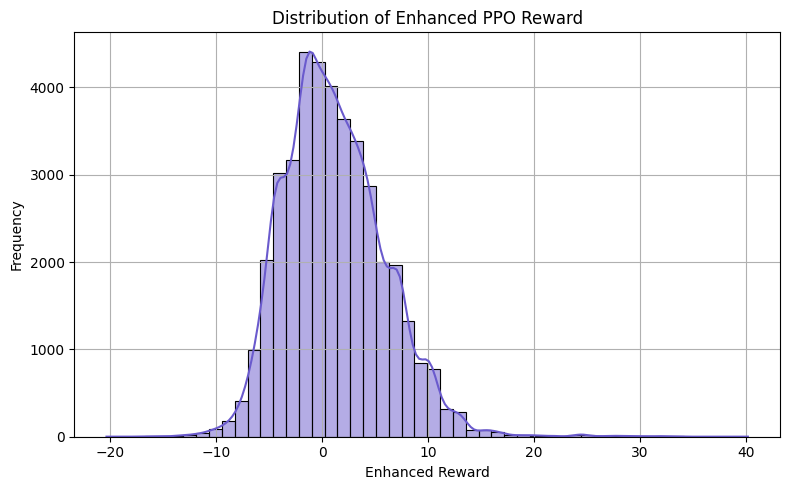

C:\Users\曦曦yyds\AppData\Local\Temp\ipykernel_28164\1256153242.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




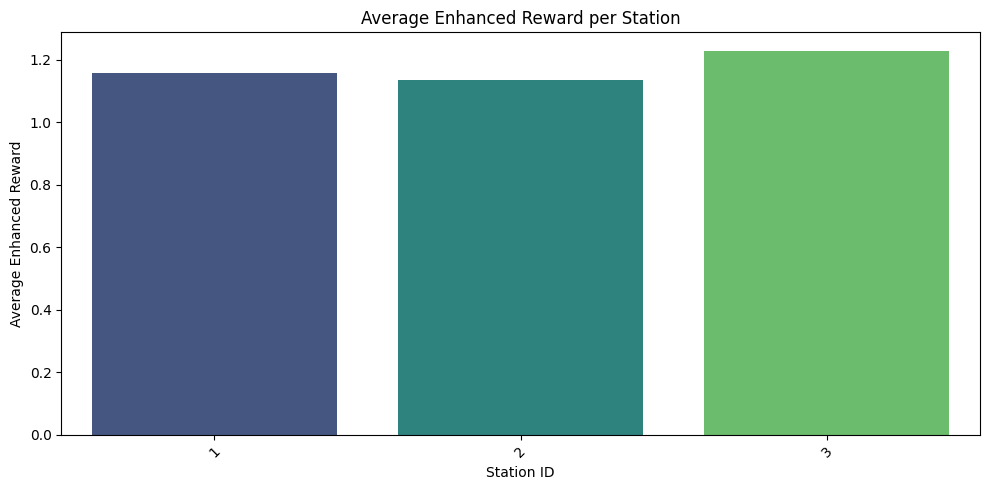

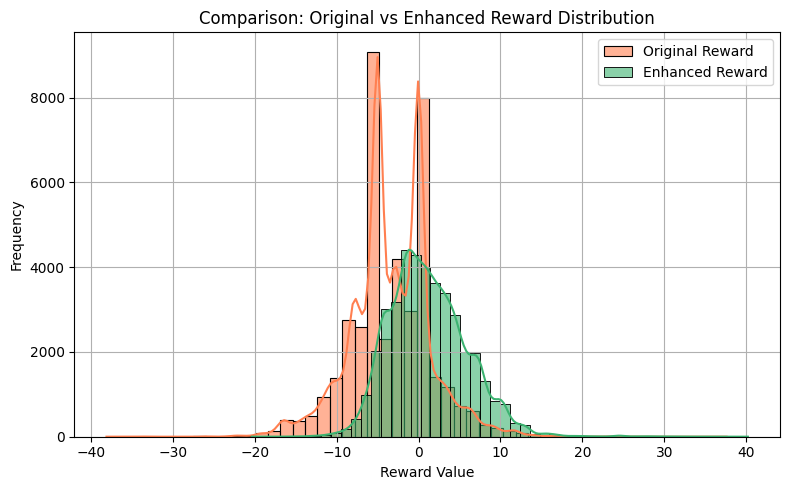

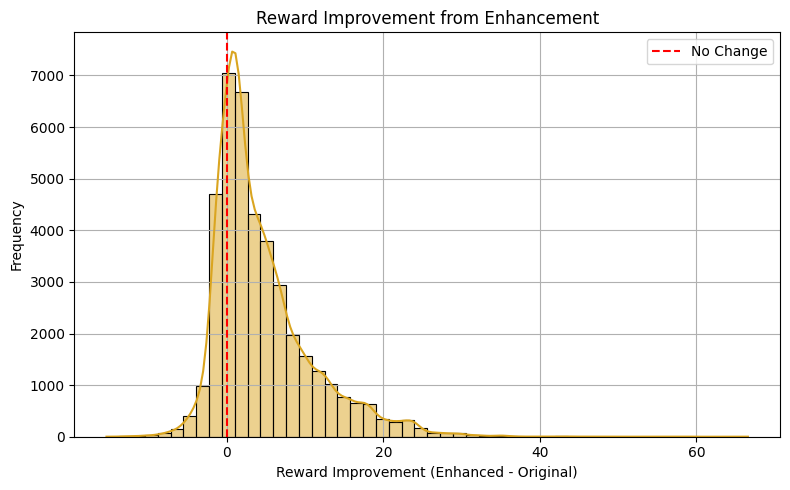

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\曦曦yyds\Desktop\ppo_enhanced_reward.csv")

# Distribution of Enhanced Reward
plt.figure(figsize=(8, 5))
sns.histplot(df['enhanced_reward'], bins=50, kde=True, color='slateblue')
plt.title("Distribution of Enhanced PPO Reward")
plt.xlabel("Enhanced Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_enhanced_reward_distribution.png")
plt.show()

# Average Reward per Station
station_avg = df.groupby('station_id')['enhanced_reward'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=station_avg.index, y=station_avg.values, palette='viridis')
plt.title("Average Enhanced Reward per Station")
plt.xlabel("Station ID")
plt.ylabel("Average Enhanced Reward")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_station_reward_barplot.png")
plt.show()


# Reward Comparison Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['reward'], bins=50, kde=True, color='coral', label='Original Reward', alpha=0.6)
sns.histplot(df['enhanced_reward'], bins=50, kde=True, color='mediumseagreen', label='Enhanced Reward', alpha=0.6)
plt.title("Comparison: Original vs Enhanced Reward Distribution")
plt.xlabel("Reward Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_reward_comparison.png")
plt.show()

# Reward Improvement per Sample
df['reward_improvement'] = df['enhanced_reward'] - df['reward']

plt.figure(figsize=(8, 5))
sns.histplot(df['reward_improvement'], bins=50, kde=True, color='goldenrod')
plt.title("Reward Improvement from Enhancement")
plt.xlabel("Reward Improvement (Enhanced - Original)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\viz_reward_improvement.png")
plt.show()

Evaluation result saved to: C:\Users\曦曦yyds\Desktop\ppo_policy_evaluation.csv


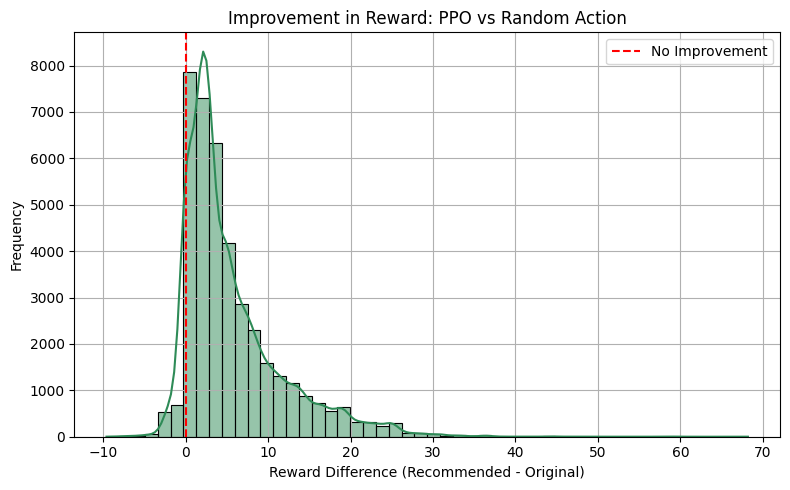

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\曦曦yyds\Desktop\ppo_user_clustered.csv"
df_eval = pd.read_csv(file_path)

# Reuse State Preprocessing
state_cols = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive_flag']
X = df_eval[state_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
states = torch.tensor(X_scaled, dtype=torch.float32)

# Predict Optimal Action Using Trained Policy
policy.eval()
with torch.no_grad():
    probs = policy(states)
    dist = Categorical(probs)
    recommended_actions = dist.sample().numpy()

# Map Action Index to Price Change
action_mapping = {0: -0.2, 1: -0.1, 2: 0.0, 3: 0.1, 4: 0.2}
df_eval['recommended_action_index'] = recommended_actions
df_eval['recommended_action_value'] = df_eval['recommended_action_index'].map(action_mapping)

# Compute Smoothed Delivered Energy (Fixed)
max_rate = 7.2
energy_gap_clipped = df_eval['energy_gap'].clip(lower=0)
park_duration_clipped = df_eval['park_duration'].clip(lower=0)
df_eval['delivered_energy'] = np.minimum(energy_gap_clipped, park_duration_clipped) * max_rate

# Compute Revenue
df_eval['revenue'] = df_eval['recommended_action_value'] * df_eval['delivered_energy']

# Compute Peak Penalty
df_eval['peak_penalty'] = df_eval['arrival_hour'].apply(lambda h: 1 if (8 <= h <= 11 or 16 <= h <= 19) else 0)

# Compute Discomfort Penalty
df_eval['discomfort_penalty'] = (
    ((df_eval['price_sensitive_flag'] == 1) & (df_eval['recommended_action_value'] > 0)).astype(int)
)

# Compute Stability Penalty
df_eval['stability_penalty'] = df_eval['recommended_action_value'].abs() * 0.5  # epsilon=0.5

# Compute Final Reward with Penalties
alpha, beta, gamma, epsilon = 1.0, 3.0, 2.0, 0.5
df_eval['recommended_reward'] = (
    alpha * df_eval['revenue']
    - beta * df_eval['peak_penalty']
    - gamma * df_eval['discomfort_penalty']
    - epsilon * df_eval['stability_penalty']
)

eval_output_path = r"C:\Users\曦曦yyds\Desktop\ppo_policy_evaluation.csv"
df_eval.to_csv(eval_output_path, index=False)
print(f"Evaluation result saved to: {eval_output_path}")

# Visualization: Reward Improvement
plt.figure(figsize=(8, 5))
sns.histplot(df_eval['recommended_reward'] - df_eval['reward'], bins=50, kde=True, color='seagreen')
plt.title("Improvement in Reward: PPO vs Random Action")
plt.xlabel("Reward Difference (Recommended - Original)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='No Improvement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\ppo_policy_eval_diff.png")
plt.show()


In [7]:
torch.save(policy.state_dict(), "ppo_policy_model.pt")

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the policy network structure
class PolicyNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)

# Load new EV user state data and standardize
# Input path for the newly simulated EV user state data
input_path = r"C:\Users\曦曦yyds\Desktop\ppo_policy_evaluation.csv"  # Replace with your new dataset path
df = pd.read_csv(input_path)

# State variable columns (consistent with training phase)
state_cols = ['arrival_hour', 'park_duration', 'energy_gap', 'demand_level_encoded', 'price_sensitive_flag']
X = df[state_cols].values

# Use the same standardization method as during training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # If you saved a scaler, replace this with the loaded scaler

states = torch.tensor(X_scaled, dtype=torch.float32)

# Load the trained policy model
model_path = r"C:\Users\曦曦yyds\Desktop\ppo_policy_model.pt"
policy = PolicyNet(in_dim=5, out_dim=5)
policy.load_state_dict(torch.load(model_path))
policy.eval()

# Generate recommended actions using the policy model
with torch.no_grad():
    probs = policy(states)
    dist = Categorical(probs)
    actions = dist.sample().numpy()

# Map action indices to price changes and save results
action_mapping = {
    0: -0.2,
    1: -0.1,
    2: 0.0,
    3: 0.1,
    4: 0.2
}

df['recommended_action_index'] = actions
df['recommended_price_change'] = df['recommended_action_index'].map(action_mapping)

output_path = r"C:\Users\曦曦yyds\Desktop\ev_users_with_pricing_action.csv"
df.to_csv(output_path, index=False)
print(f"Recommended pricing actions saved to: {output_path}")


Recommended pricing actions saved to: C:\Users\曦曦yyds\Desktop\ev_users_with_pricing_action.csv
